### Import libraries

In [2]:
import torch
import warnings
import numpy as np
import torch.nn as nn
from time import time
import matplotlib.pyplot as plt
import albumentations as A

from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from datasets.gta5 import GTA5
from datasets.cityscapes import CityScapes
from torchvision.transforms import ToPILImage
from torchvision import transforms

from utils import fast_hist, per_class_iou
from models.bisenet.build_bisenet import BiSeNet

warnings.filterwarnings("ignore")

### Training

In [4]:
device = torch.device("cuda")
# Load model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)

# Set model to training mode
model.train()

# Define the custom transform to augment the data
custom_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
])

# Load the dataset
dataset = GTA5(root_dir='datasets/GTA5', custom_transform=custom_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Set model to training mode
model.train()
# Training loop
for epoch in range(50):
    hist = np.zeros((19, 19))
    # Iterate over the dataset
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        # Move the data to the device
        images = images.to(device)
        label = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(images)[0]
        # Compute the loss
        loss = criterion(output, label)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)

        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/bisenet/bisenet_gta5.pth')

100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 0, Loss: 0.5071824193000793, mIoU: 0.2102345647951476


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 1, Loss: 0.5525911450386047, mIoU: 0.277011375760999


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 2, Loss: 0.26196426153182983, mIoU: 0.2995683362440538


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 3, Loss: 0.3917083442211151, mIoU: 0.3180143811956153


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 4, Loss: 0.2609800100326538, mIoU: 0.330762003997412


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 5, Loss: 0.2258085161447525, mIoU: 0.3528421224068885


100%|██████████| 313/313 [02:07<00:00,  2.45it/s]


Epoch: 6, Loss: 0.2634415030479431, mIoU: 0.37426193261858276


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 7, Loss: 0.35749244689941406, mIoU: 0.40357953108174976


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 8, Loss: 0.33488112688064575, mIoU: 0.4320818531381879


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 9, Loss: 0.31007495522499084, mIoU: 0.4532478626268283


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 10, Loss: 0.23166339099407196, mIoU: 0.46326348433758946


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 11, Loss: 0.2795523405075073, mIoU: 0.4787547430408922


100%|██████████| 313/313 [02:07<00:00,  2.45it/s]


Epoch: 12, Loss: 0.19267049431800842, mIoU: 0.489471338302025


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 13, Loss: 0.23189117014408112, mIoU: 0.4998513960922538


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 14, Loss: 0.17041999101638794, mIoU: 0.5086989003514656


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 15, Loss: 0.18302416801452637, mIoU: 0.5150425173560035


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 16, Loss: 0.1730557233095169, mIoU: 0.5277030329550128


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 17, Loss: 0.1810069978237152, mIoU: 0.5325545309514442


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 18, Loss: 0.17055962979793549, mIoU: 0.5405394055732063


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 19, Loss: 0.1827394664287567, mIoU: 0.5447970404309977


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 20, Loss: 0.20691373944282532, mIoU: 0.5481762733102278


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 21, Loss: 0.1553918421268463, mIoU: 0.555838985517454


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 22, Loss: 0.21670004725456238, mIoU: 0.562284573105726


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 23, Loss: 0.18175990879535675, mIoU: 0.5660718710125215


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 24, Loss: 0.18821874260902405, mIoU: 0.5691245428250771


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 25, Loss: 0.18060049414634705, mIoU: 0.5762693186170639


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 26, Loss: 0.1512165665626526, mIoU: 0.5793865261391501


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 27, Loss: 0.1742320954799652, mIoU: 0.5810165827253527


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 28, Loss: 0.2490415871143341, mIoU: 0.5825447872222254


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 29, Loss: 0.19090773165225983, mIoU: 0.5868325547384685


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 30, Loss: 0.17588487267494202, mIoU: 0.5904163158572441


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 31, Loss: 0.15834303200244904, mIoU: 0.5938899486835963


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 32, Loss: 0.18321435153484344, mIoU: 0.5950853249453477


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 33, Loss: 0.14718610048294067, mIoU: 0.6030669473781243


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 34, Loss: 0.17507465183734894, mIoU: 0.6006735760830669


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 35, Loss: 0.1409110724925995, mIoU: 0.6067484735113076


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 36, Loss: 0.17117905616760254, mIoU: 0.6083150468865878


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 37, Loss: 0.17222638428211212, mIoU: 0.6132939441283979


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 38, Loss: 0.13984188437461853, mIoU: 0.6110421943357188


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 39, Loss: 0.17412321269512177, mIoU: 0.6150735953176159


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 40, Loss: 0.13376900553703308, mIoU: 0.6175431448048045


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 41, Loss: 0.16135670244693756, mIoU: 0.6198277799652372


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 42, Loss: 0.14153483510017395, mIoU: 0.6221766696361485


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 43, Loss: 0.11819811165332794, mIoU: 0.6221419749954282


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch: 44, Loss: 0.15879346430301666, mIoU: 0.6271181093892949


100%|██████████| 313/313 [02:04<00:00,  2.50it/s]


Epoch: 45, Loss: 0.15130427479743958, mIoU: 0.6312293635074315


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch: 46, Loss: 0.11216943711042404, mIoU: 0.6301650689273879


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 47, Loss: 0.1372131109237671, mIoU: 0.6326928236451215


100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch: 48, Loss: 0.1709349900484085, mIoU: 0.6362060158609423


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]

Epoch: 49, Loss: 0.18266448378562927, mIoU: 0.6341138997420678


### Evaluation - GTA 5

0it [00:00, ?it/s]


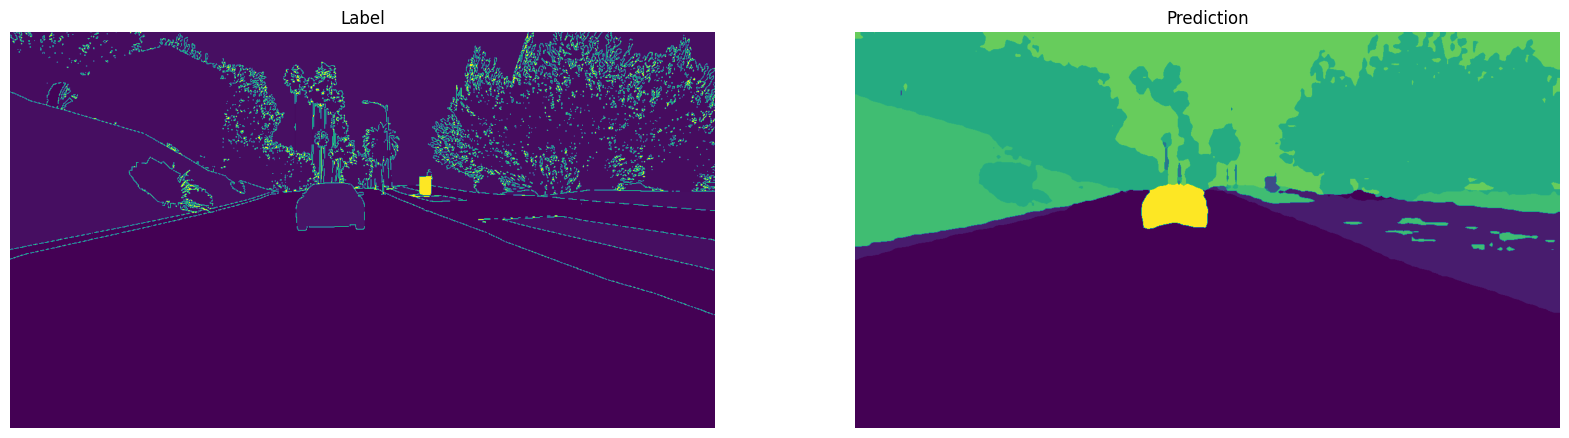

In [6]:
## Evaluation
# Get the device
device = torch.device("cuda")
# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_gta5.pth'))
# Set model to evaluation mode
model.eval()

# Load the dataset
# Load the dataset
dataset = GTA5(root_dir='datasets/GTA5')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

for i, (image, label) in tqdm(enumerate(dataloader)):
    # Move the data to the device
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Stop after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()

### Evaluation - CityScapes

In [8]:
# These are the class labels for the Cityscapes dataset
class_labels = {
    0: 'road',
    1: 'sidewalk',
    2: 'building',
    3: 'wall',
    4: 'fence',
    5: 'pole',
    6: 'traffic light',
    7: 'traffic sign',
    8: 'vegetation',
    9: 'terrain',
    10: 'sky',
    11: 'person',
    12: 'rider',
    13: 'car',
    14: 'truck',
    15: 'bus',
    16: 'train',
    17: 'motorcycle',
    18: 'bicycle'
}

In [9]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_gta5.pth'))
# Set model to evaluation mode
model.eval()

## Get the miou for the Cityscapes dataset in the training split
# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=6)

# Evaluate the model
hist = np.zeros((19, 19))
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)

## Get the miou for the Cityscapes dataset in the validation split
# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=6)

# Evaluate the model
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    
# Calculate the mean IoU
miou = np.mean(per_class_iou(hist))
print(f"Mean IoU: {miou:.4f} \n")

class_ious = per_class_iou(hist)
# Print per-class IoU
for i, iou in enumerate(class_ious):
    print(f"{class_labels[i]} IoU: {iou:.4f}")

100%|██████████| 500/500 [00:06<00:00, 82.59it/s]

Mean IoU: 0.2955 

road IoU: 0.7644
sidewalk IoU: 0.2370
building IoU: 0.7210
wall IoU: 0.1363
fence IoU: 0.2069
pole IoU: 0.1343
traffic light IoU: 0.0605
traffic sign IoU: 0.0427
vegetation IoU: 0.7686
terrain IoU: 0.2436
sky IoU: 0.7032
person IoU: 0.4168
rider IoU: 0.0002
car IoU: 0.6632
truck IoU: 0.1301
bus IoU: 0.1260
train IoU: 0.0500
motorcycle IoU: 0.1906
bicycle IoU: 0.0189


### Example

0it [00:00, ?it/s]


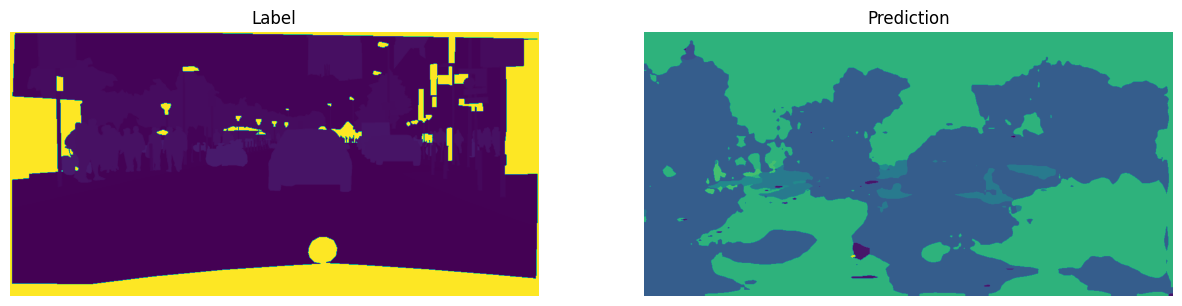

In [9]:
## Inference
# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_gta5.pth'))
# Set model to evaluation mode
model.eval()

custom_transform = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
    # Normalize the image using the mean and standard deviation of GTA 5 dataset
    transforms.Normalize(
        mean=[0.5084, 0.5021, 0.4838], 
        std=[0.2490, 0.2440, 0.2424]),
])

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', 
                     split='val', mode='single', raw_label=False, 
                     custom_transform_image=custom_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

for i, (image, label) in tqdm(enumerate(dataloader)):
    # Move the data to the device
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Stop after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()